# Reinforcement Learning &#x2013; Continuous State Spaces

**Prerequisites**

- Tensorflow
- Function Approximation/Interpolation
- Reinforcement Learning Introduction, Sarsa, QLearning

**Outcomes**

- Understand the limits of tabular RL algorithms when facing continuous state or action spaces
- Be able to apply linear interpolation as a function approximation tool for representing $Q$
- Be able to use tensorflow to use a neural network to approximate $Q$

**References**

- Barto & Sutton book (online by authors [here](http://incompleteideas.net/book/the-book.html)) chapters 9-11

## Tabular Q &#x2013; review

- Previous examples (farkle, career choice) have had discrete state and action spaces
    - Career choice: 
    $$\begin{aligned}
    \mathcal{S} &= \{\epsilon_i\}_{i=1}^N \times \{\theta_i\}_{i=1}^N \\ 
    \mathcal{A} &= \{\text{ stay put}, \text{ new job}, \text{ new life}\}
    \end{aligned}$$
    - Farkle: 
    $$\begin{aligned}
    \mathcal{S} &= \text{round} \times \text{scores} \times \text{can roll} \times \text{rolled} \times \text{turn sum} \\ 
    \mathcal{A}(s) &\subseteq \text{roll} \times \text{stop} \times \text{play dice}
    \end{aligned}$$
- This allowed us to use a lookup table for storing $Q(s, a)$
    - Q was a dict, each key was $(s, a)$ pair and each value was associated Q

### Tabular Q &#x2013; limitations

- Not all environments or RL problems have discrete state and action spaces
- Some have much larger state or action spaces
    - Self driving car: all possible images, sensor readings
    - Stock trading: sequences of prices, liquidity, funds
    - Medical imaging: all possible medical images
- Using a lookup table (dict) to represent $Q$ in these cases is not feasible
- We need a *generalization* strategy for $Q$
- Our response: *function approximation*

## Example: Cart-Pole



-   As a motivating example, let's consider the Cart-Pole problem
-   in this problem a pole is fastened to the side of a cart, loose enough for
    the pole to freely rotate
-   The agent must move the cart on a straight line (1 dimension) to keep the
    pole from falling below a certain angle

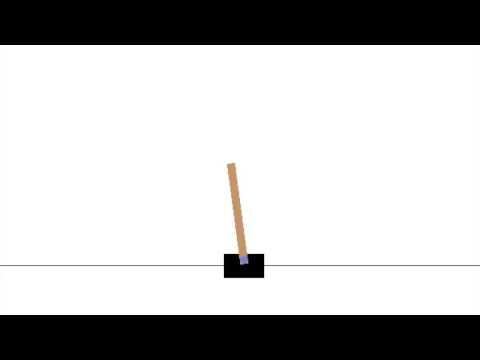

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("46wjA6dqxOM", width=800, height=600)

### State Space

- $\mathcal{S} \subset \mathbb{R}^4$
  | Num|Observation|Min|Max|
  |---|---|---|---|
  | 0|Cart Position|-4.8|4.8|
  | 1|Cart Velocity|-Inf|Inf|
  | 2|Pole Angle|-0.418 rad (-24 deg)|0.418 rad (24 deg)|
  | 3|Pole Angular Velocity|-Inf|Inf|
- This is a continuous space and therefore using a lookup table is infeasible (infinitely many $s \in \mathcal{S})$

### Action Space



- $\mathcal{A} = {0, 1}$:
    
  | Num|Action|
  |---|---|
  | 0|Push cart to the left|
  | 1|Push cart to the right|

- Action space is discrete

### OpenAI Gym

- OpenAI is a ML research company from the US
- Now famous for NLP models such as ChatGPT
- A few years ago created the `gym` python library for RL research
- `gym` contains implementations of dozens of RL environments that adhere to a consistent API
- Researchers can implement RL agents once and test them on a variety of RL problems
- Since focusing on ChatGPT, OpenAI has stopped developing and maintaining gym
- A team from  the Farama Foundation has created a fork of the project and released a new python package called `gymnasium`. We will use this package

### Cartpole in Gym

- Let's load up the gym library and see how it works
- We first import gym and call `gym.make` with the name of our env (`CartPole-v0`)

In [2]:
# if you get errors importing gym below, try to uncomment line below to install gym
# %pip install --user gymnasium interpolation

In [3]:
import gymnasium as gym
import random
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [4]:
env = gym.make("CartPole-v1")

#### State Space

- We can ask gym to tell us the state space for an env

In [5]:
env.observation_space

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

- `Box` with 4 dimensions means a continus subspace of $\mathbb{R}^4$
- We can ask for the minimum and maximum value for each of the Box' dimensions

In [6]:
print("min: ", env.observation_space.low)
print("max: ", env.observation_space.high)

min:  [-4.8               -inf -0.41887903        -inf]
max:  [4.8               inf 0.41887903        inf]


#### Action Space

- We can also ask for the action space

In [7]:
env.action_space

Discrete(2)

- Discrete spaces contain the elements ${0, \dots, N-1}$
- In this case we have $\mathcal{A} = \{0, 1\}$

In [8]:
0 in env.action_space

True

In [9]:
2 in env.action_space

False

#### Sampling from spaces

- We can sample from spaces

In [10]:
print("sample s: ", env.observation_space.sample())
print("sample a: ", env.action_space.sample())

sample s:  [ 1.3869437  -2.3312354   0.25096324 -0.72174555]
sample a:  1


#### A sample episode

- Let's use a completely random agent to showcase how gym works
- See comments in the code

In [11]:
# restart the env. Will return s_0
s = env.reset()
for t in range(100):
    env.render()                    # update display
    time.sleep(0.1)
    print(s)                        # print s
    a = env.action_space.sample()   # random sample from A(s)
    s, r, done, _truncated, _info = env.step(a)  # step using a
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

(array([ 0.0075384 , -0.01020942, -0.01436173,  0.01373782], dtype=float32), {})


/Users/sglyon/miniforge3/envs/cap-6318/lib/python3.12/site-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


[ 0.00733422  0.18511552 -0.01408698 -0.28344157]
[ 0.01103653  0.38043553 -0.01975581 -0.580534  ]
[ 0.01864524  0.5758287  -0.03136649 -0.8793743 ]
[ 0.03016181  0.7713624  -0.04895397 -1.1817509 ]
[ 0.04558906  0.5769088  -0.07258899 -0.9048067 ]
[ 0.05712724  0.7729348  -0.09068512 -1.2193937 ]
[ 0.07258593  0.57909125 -0.115073   -0.956448  ]
[ 0.08416776  0.775557   -0.13420196 -1.2829545 ]
[ 0.0996789   0.5823748  -0.15986104 -1.0351238 ]
[ 0.11132639  0.3896975  -0.18056352 -0.7965922 ]
[ 0.11912034  0.58677685 -0.19649537 -1.1402029 ]
Episode finished after 12 timesteps


#### Many sample episodes

- Let's play many sample episodes and see how the random agent does over time

In [12]:
random_episode_length = []
for _ in range(5000):
    env.reset()
    for n_steps in range(200):
        a = env.action_space.sample()
        _, _, done, _, _ = env.step(a)
        if done:
            random_episode_length.append(n_steps)
            break

<Axes: >

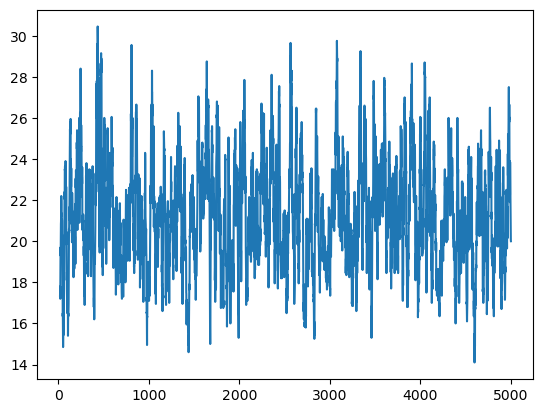

In [13]:
pd.Series(random_episode_length).rolling(20).mean().plot()

- This agent does not do well...
- The CartPole env terminates successfully after 200 steps. 
- This agent doesn't quite get 15% of the way there
- To do better we need some tools for handling the continuous state space

## Linear Function Approximation

- Let's begin our generalizing Q with linear function approximation
- Let $x(s): \mathcal{S} \rightarrow \mathbb{R}^D$ be a feature map for state $s$
- $x$ could be identity function, polynomial features, spline basis functions, etc
- For the discrete action space case we will let $w_a \in \mathbb{R}^D$ represent weights such that $$Q(s, a | w) = w_a^Tx(s)$$
- Notice that our approximation to $Q$ is linear in the features $x(s)$

### SGD

- We would like to choose weights $w_a$ that minimize the difference between $q^*(s,a)$ and $Q(s,a|w_a)$
- To do this we will use the MSE loss function between $q^*(s,a)$ and $Q(s,a|w_a)$
- If we apply SGD using this loss function, we want to update $w$ as follows:
$$\begin{aligned}
w_A &= w_A - \frac{1}{2} \alpha \nabla_w \big[q^*(S,A) - Q(S, A | w) \big]^2 \\
     &= w_A + \alpha \big[q^*(S, A) - Q(S, A | w) \big] \nabla_w Q(S, A | w)
\end{aligned}$$
- The issue is that we don't know $q^*(S, A)$...

### TD(0) to the rescue

- Notice how the update rule for $w_A$ looks very similar to the update rule for tabular Q-learning:
$$\begin{aligned}
w_A &= w_A + \alpha \big[q^*(S, A) - Q(S, A | w) \big] \nabla_w Q(S, A | w) \\
Q(S, A) &= Q(S, A) + \alpha \big[R + \beta \max_{a'} Q(S', a') - Q(S, A) \big]
\end{aligned}$$
- In Q-learning we take small steps in the direction of $q^*(s, a)$ using the TD(0) error
- We'll extend this knowledge to the SGD for $w_A$ and use $R + \beta \max_{a'} Q(S', a'| w)$ in place of $q^*(S, A)$:
$$w_A = w_A + \alpha \big[R + \beta \max_{a'} Q(S', a'| w) - Q(S, A | w) \big] \nabla_w Q(S, A | w)$$
- There are proofs that provide guarantees that if we use this update rule $Q(s, a | w)$ will converge to $q^*$
- We will take these proofs as given

### SGD + TD(0) + Linear Approximator

- We now combine the concepts of SGD, TD(0) learning, *and* the fact that we consider forms of $Q(s, a | w) = w_a^Tx(s)$ that are linear in features $x(s)$
- Under our linearity assumption $$\nabla_w Q(s, a | w) = x(s)$$
- This makes our update rule for $w$ equal to: $$w_A = w_A + \alpha \big[R + \beta \max_{a'} Q(S', a'| w) - Q(S, A | w) \big] x(s)$$
- Note that the TD(0) part of the update rule is a scalar
- We update our weights in the direction of our feature vector $x(s)$, with scaled step size according to TD(0) term and learning rate

### Example: Complete Polynomials

- Let's try this procedure out using a function $x(s)$ that computes a complete polynomial in $s$
- A complete polynomial of degree $D$ is composed of all possible multiplicative terms of the elements $s$ that are of total degree less than or equal to $D$
    - Example: $s = [a, b, c]$ and $D = 2$: $$x(s) = \begin{bmatrix}1 & a & b & c & a^2 & a b & a c & b^2 & b c & c^2 \end{bmatrix}^T$$
    - Does not include $a^2 b$ term because that has total degree of $3 > 2$

In [14]:
from interpolation.complete_poly import complete_polynomial
complete_polynomial([1, 2, 3], 2)

array([1., 1., 2., 3., 1., 2., 3., 4., 6., 9.])

- We'll now create a class that uses `complete_polynomial` under the hood, and keeps track of `w` for us

In [15]:
class CompletePolyInterpolator:
    def __init__(self, N: int, D: int=2):
        self.D = D
        self.w = np.random.rand(complete_polynomial(np.zeros(N), D).size)

    def basis(self, s):
        "return basis matrix x(s)"
        return complete_polynomial(s, self.D)

    def __call__(self, s):
        return self.basis(s) @ self.w

- We'll wrap this in a class that stores one `CompletePolyInterpolator` per discrete action

In [16]:
class ContinuousSDiscreteAQ:
    def __init__(self,  Ndim_s: int, Na:int, approximator = CompletePolyInterpolator):
        self.Q = [approximator(Ndim_s) for _ in range(Na)]
        self.Na = Na

    @property
    def w(self):
        return np.row_stack([Qa.w for Qa in self.Q])

    def __call__(self, s, a):
        return self.Q[a](s)

    def __getitem__(self, a):
        return self.Q[a]

    def basis(self, s, a):
        return self.Q[a].basis(s)

    def get_greedy(self, s, A_s):
        vals = [self(s, a) for a in A_s]
        max_val = max(vals)
        return random.choice([a for (a, v) in zip(A_s, vals) if v == max_val])

- And now we'll create a Qlearning class that can leverage it

In [17]:
class ApproxQlearning(object):
    def __init__(
            self,
            environment,
            approximator=CompletePolyInterpolator,
            epsilon=0.9, alpha=0.05, beta=0.5
        ):
        self.env = environment
        Ns = env.observation_space.shape[0]

        assert isinstance(env.action_space, gym.spaces.Discrete)
        Na = env.action_space.n
        self.A_s = np.arange(Na)
        self.Q = ContinuousSDiscreteAQ(Ns, Na, approximator=approximator)
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta

        self.restart_episode()

    def restart_episode(self):
        self.s, _ = self.env.reset()

    def get_greedy(self, s):
        return self.Q.get_greedy(s, self.A_s)

    def generate_A(self, s):
        if random.random() > self.epsilon:
            return self.env.action_space.sample()
        return self.get_greedy(s)

    def step(self):
        s = self.s

        # first generate an A
        a = self.generate_A(s)

        # take step
        sp, r, done, _truncated, _info = self.env.step(a)

        if done:
            # game is over
            self.s = sp
            return done

        # get greedy a' based on Q and sp
        ap = self.get_greedy(sp)

        # Do TD update
        Q, α, β = self.Q, self.alpha, self.beta  # simplify notation
        Q[a].w = Q[a].w + α * (r + β * Q(sp, ap) - Q(s, a)) * Q[a].basis(s)

        # step forward in time
        self.s = sp

- We'll train qlearning for 5,000 steps and again plot the average number of steps per game

array([[ 5.00492552,  0.19912004, -0.08320478,  0.27513399, -0.26938976,
         0.23661453, -0.52072202,  0.53717357,  0.21791391, -0.07590896,
         0.46026611,  0.52539979,  0.44715695, -0.38673576, -0.78948703],
       [ 4.92245639, -0.18349037, -0.34407016,  0.86556602,  0.41057937,
         0.01922148, -0.65441385,  0.55113471,  0.6271257 , -0.28140334,
         1.76937448,  0.3524834 ,  0.98064187, -0.68667117, -0.89428512]])

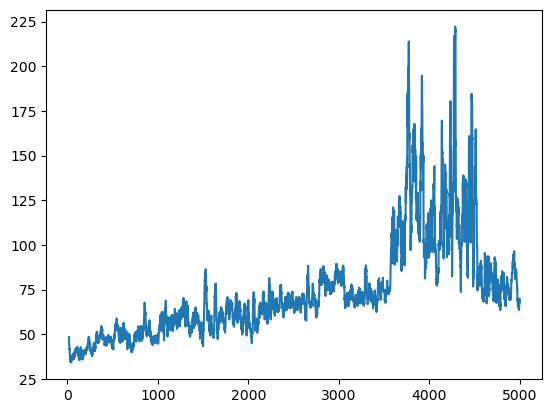

In [18]:
ql = ApproxQlearning(env, epsilon=0.98, beta=0.8, alpha=0.05)

def play_episode(ql, render=False):
    ql.env.reset()
    done = False
    i = 0
    while not done:
        i += 1
        if render:
            ql.env.render()
        done = ql.step()

    if render:
        env.close()

    return i

episode_length = [play_episode(ql) for _ in range(5_000)]

pd.Series(episode_length).rolling(20).mean().plot()

ql.Q.w

#### Summary

- Our complete polynomial approximation seems to do better than random
- This is a good start, but this has its limits:
    - Only way to add more flexibility to our approximator is increase polynomial degree
    - The min/max values for the velocity variables are extreme
    - Trying to compute quadratic or greater terms in very large values will likely cause numerical instability
- We need a different paradigm for representing $Q$ in a more flexible, but numerically stable way